
# Customer Spending Prediction using Linear Regression

## Business Context
E-commerce and subscription apps need to understand how user engagement  
(time spent in app) correlates with customer spending to optimize features,  
marketing strategies, and revenue forecasting.

## Problem Statement
Can we predict customer spending based solely on their app usage time?  
This helps identify high-value users early and tailor experiences accordingly.


## Install Required Libraries into the Current Jupyter Kernel


In [12]:
%pip install --upgrade pip
%pip install numpy pandas matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
import numpy as np  # Numerical computing
import pandas as pd  # Data manipulation

# Visualization
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns  # Statistical visualization
from matplotlib.cm import viridis  # Color map

# Machine learning
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.linear_model import LinearRegression  # Our model
from sklearn.metrics import (  # Evaluation metrics
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)

# System utilities
import warnings
warnings.filterwarnings('ignore')  # Clean output

# Visualization configuration
plt.style.use('seaborn-v0_8-whitegrid')  # Clean, professional style
sns.set_palette("rocket")  # Business-friendly color palette
plt.rcParams['figure.figsize'] = (12, 8)  # Default figure size
plt.rcParams['font.size'] = 12  # Readable font size
%matplotlib inline

print("📚 Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


📚 Libraries imported successfully!
NumPy version: 2.4.0
Pandas version: 2.3.3



## Data Generation: Customer Engagement Data

We'll simulate realistic customer behavior data:
- **App usage time** (`Usage_Minutes`) — predictor (minutes per month)
- **Monthly spending** (`Monthly_Spending`) — target ($)
- Includes realistic noise, mild saturation effect at very high usage, and a few outliers



In [14]:
np.random.seed(42)

# Generate sample size
n_customers = 200

# Create app usage time (minutes per month)
# Realistic distribution: most users 30-120 mins, some heavy users up to 300
usage_time = np.random.exponential(scale=60, size=n_customers) + 30
usage_time = np.clip(usage_time, 5, 300)  # Keep within realistic bounds

# Create spending based on usage with diminishing returns
# Base model: Spending = log(usage) * coefficient + noise
base_spending = 15  # Minimum spend for any user
spending_coefficient = 40  # Dollars per log(minute)

# Apply diminishing returns: log transformation
log_usage = np.log1p(usage_time)  # log(1+x) to handle low values

# Generate spending with noise
spending = base_spending + (log_usage * spending_coefficient) + np.random.normal(0, 15, n_customers)

# Ensure no negative spending
spending = np.maximum(spending, 5)

# Create customer IDs for tracking
customer_ids = [f"CUST{str(i+1).zfill(4)}" for i in range(n_customers)]

# Create DataFrame
customer_data = pd.DataFrame({
    'Customer_ID': customer_ids,
    'Usage_Minutes': np.round(usage_time, 2),
    'Monthly_Spending': np.round(spending, 2)
})

# Display overview
print("📊 CUSTOMER DATA OVERVIEW")
print("=" * 50)
print(f"Total customers: {len(customer_data)}")
print(f"Features: {list(customer_data.columns)}")

print("\n📋 First 5 Customers:")
print(customer_data.head().to_string(index=False))

print("\n📈 Data Summary:")
print(customer_data.describe().round(2))

📊 CUSTOMER DATA OVERVIEW
Total customers: 200
Features: ['Customer_ID', 'Usage_Minutes', 'Monthly_Spending']

📋 First 5 Customers:
Customer_ID  Usage_Minutes  Monthly_Spending
   CUST0001          58.16            168.01
   CUST0002         210.61            232.67
   CUST0003         109.00            207.42
   CUST0004          84.78            182.35
   CUST0005          40.18            191.70

📈 Data Summary:
       Usage_Minutes  Monthly_Spending
count         200.00            200.00
mean           86.73            188.31
std            54.73             26.55
min            30.33            124.07
25%            45.57            167.64
50%            70.93            187.30
75%           114.84            208.62
max           290.05            260.35



## Exploratory Data Analysis (EDA)

**Objective:** Understand data distributions, relationships, and identify insights before modeling.

**What we'll explore:**
- Data preview, types, and summary statistics
- Missing values and basic quality checks
- Univariate distributions (histogram, KDE, boxplot)
- Bivariate relationships (scatter with regression line, joint plot)
- Correlation matrix
- Outlier inspection



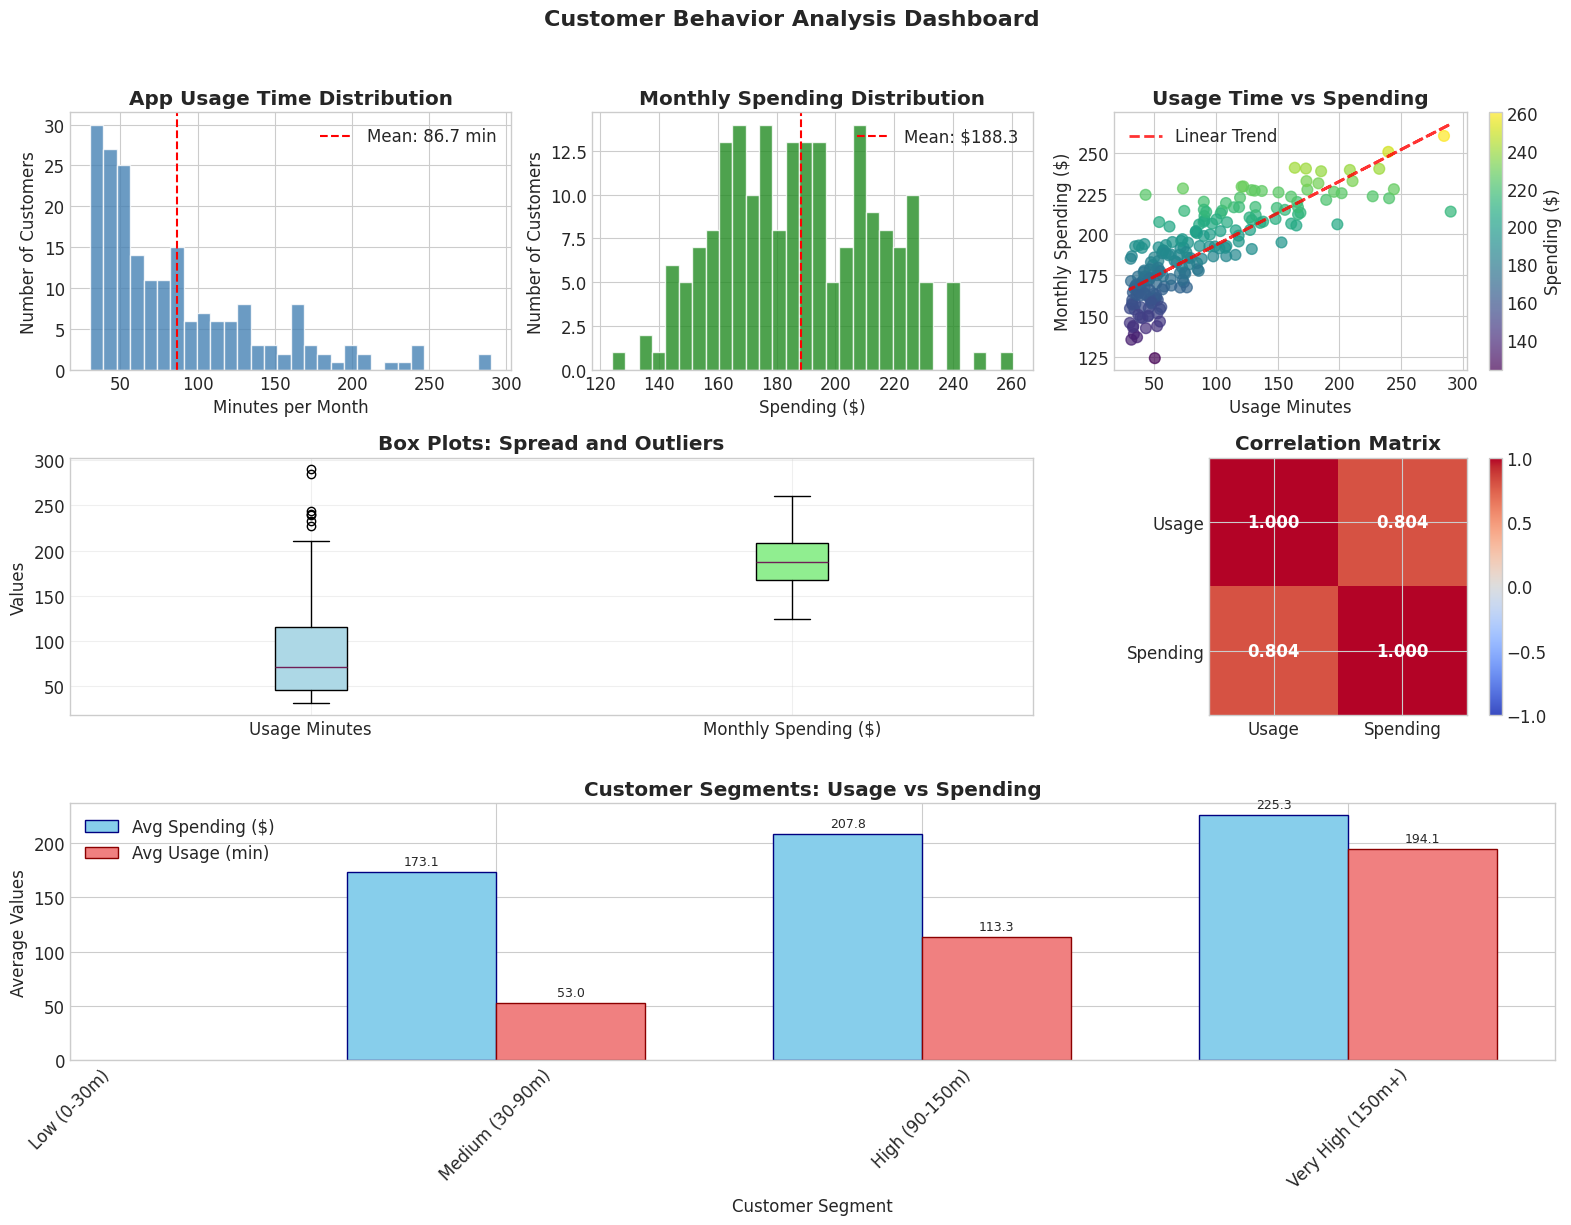


🔍 KEY INSIGHTS FROM EDA:
1. Strong positive correlation: 0.804
2. Usage distribution is right-skewed (typical for engagement data)
3. Higher usage correlates with higher spending (diminishing returns visible)
4. Segment analysis shows Low (0-30m) users spend $nan avg
   vs Very High (150m+) users: $225.3 avg


In [15]:
fig = plt.figure(figsize=(16, 12))
fig.suptitle('Customer Behavior Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)

# Grid for subplots
gs = fig.add_gridspec(3, 3)

# 1. Distribution of Usage Minutes
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(customer_data['Usage_Minutes'], bins=30, edgecolor='white', alpha=0.8, color='steelblue')
ax1.set_title('App Usage Time Distribution', fontweight='bold')
ax1.set_xlabel('Minutes per Month')
ax1.set_ylabel('Number of Customers')
ax1.axvline(customer_data['Usage_Minutes'].mean(), color='red', linestyle='--', 
           label=f'Mean: {customer_data["Usage_Minutes"].mean():.1f} min')
ax1.legend()

# 2. Distribution of Monthly Spending
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(customer_data['Monthly_Spending'], bins=30, edgecolor='white', alpha=0.8, color='forestgreen')
ax2.set_title('Monthly Spending Distribution', fontweight='bold')
ax2.set_xlabel('Spending ($)')
ax2.set_ylabel('Number of Customers')
ax2.axvline(customer_data['Monthly_Spending'].mean(), color='red', linestyle='--',
           label=f'Mean: ${customer_data["Monthly_Spending"].mean():.1f}')
ax2.legend()

# 3. Scatter plot: Usage vs Spending (main relationship)
ax3 = fig.add_subplot(gs[0, 2])
scatter = ax3.scatter(customer_data['Usage_Minutes'], customer_data['Monthly_Spending'],
                     c=customer_data['Monthly_Spending'], cmap='viridis', alpha=0.7, s=60)
ax3.set_title('Usage Time vs Spending', fontweight='bold')
ax3.set_xlabel('Usage Minutes')
ax3.set_ylabel('Monthly Spending ($)')
plt.colorbar(scatter, ax=ax3, label='Spending ($)')

# Add trend line for initial insight
z = np.polyfit(customer_data['Usage_Minutes'], customer_data['Monthly_Spending'], 1)
p = np.poly1d(z)
ax3.plot(customer_data['Usage_Minutes'], p(customer_data['Usage_Minutes']), 
        'r--', linewidth=2, alpha=0.8, label='Linear Trend')
ax3.legend()

# 4. Box plots for outlier detection
ax4 = fig.add_subplot(gs[1, :2])
box_data = [customer_data['Usage_Minutes'], customer_data['Monthly_Spending']]
box = ax4.boxplot(box_data, patch_artist=True, labels=['Usage Minutes', 'Monthly Spending ($)'])
# Color the boxes
box['boxes'][0].set_facecolor('lightblue')
box['boxes'][1].set_facecolor('lightgreen')
ax4.set_title('Box Plots: Spread and Outliers', fontweight='bold')
ax4.set_ylabel('Values')
ax4.grid(True, alpha=0.3)

# 5. Correlation heatmap
ax5 = fig.add_subplot(gs[1, 2])
correlation = customer_data[['Usage_Minutes', 'Monthly_Spending']].corr()
im = ax5.imshow(correlation, cmap='coolwarm', vmin=-1, vmax=1)
ax5.set_xticks([0, 1])
ax5.set_yticks([0, 1])
ax5.set_xticklabels(['Usage', 'Spending'])
ax5.set_yticklabels(['Usage', 'Spending'])
ax5.set_title('Correlation Matrix', fontweight='bold')

# Add correlation values to heatmap
for i in range(2):
    for j in range(2):
        text = ax5.text(j, i, f'{correlation.iloc[i, j]:.3f}',
                       ha="center", va="center", color="white", fontweight='bold')
plt.colorbar(im, ax=ax5)

# 6. Customer segments visualization
ax6 = fig.add_subplot(gs[2, :])
# Create customer segments
customer_data['Segment'] = pd.cut(customer_data['Usage_Minutes'],
                                 bins=[0, 30, 90, 150, 300],
                                 labels=['Low (0-30m)', 'Medium (30-90m)', 
                                         'High (90-150m)', 'Very High (150m+)'])

segment_analysis = customer_data.groupby('Segment').agg({
    'Monthly_Spending': ['mean', 'count'],
    'Usage_Minutes': 'mean'
}).round(2)

# Bar chart for segment analysis
segments = segment_analysis.index
x_pos = np.arange(len(segments))
width = 0.35

bars1 = ax6.bar(x_pos - width/2, segment_analysis[('Monthly_Spending', 'mean')],
               width, label='Avg Spending ($)', color='skyblue', edgecolor='navy')
bars2 = ax6.bar(x_pos + width/2, segment_analysis[('Usage_Minutes', 'mean')],
               width, label='Avg Usage (min)', color='lightcoral', edgecolor='darkred')

ax6.set_xlabel('Customer Segment')
ax6.set_ylabel('Average Values')
ax6.set_title('Customer Segments: Usage vs Spending', fontweight='bold')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(segments, rotation=45)
ax6.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Display key insights
print("\n🔍 KEY INSIGHTS FROM EDA:")
print("=" * 50)
print(f"1. Strong positive correlation: {correlation.iloc[0, 1]:.3f}")
print("2. Usage distribution is right-skewed (typical for engagement data)")
print("3. Higher usage correlates with higher spending (diminishing returns visible)")
print(f"4. Segment analysis shows {segment_analysis.index[0]} users spend ${segment_analysis.iloc[0,0]:.1f} avg")
print(f"   vs {segment_analysis.index[-1]} users: ${segment_analysis.iloc[-1,0]:.1f} avg")

# Remove segment column for modeling
customer_data = customer_data.drop('Segment', axis=1)


## Data Preparation

**Goal:** Prepare data for machine learning by:
1. Separating features (X) and target (y)
2. Creating train/test splits
3. Ensuring proper data shapes
4. Handling basic data quality checks (missing values, types)



🔧 DATA PREPARATION SUMMARY
Feature (X) shape: (200, 1) → 200 samples, 1 feature
Target (y) shape: (200,) → 200 target values

Feature range: 30.3 to 290.1 minutes
Target range: $124.07 to $260.35

📊 TRAIN/TEST SPLIT DETAILS
------------------------------
Training set: 160 customers (80.0%)
Test set: 40 customers (20.0%)

📈 DISTRIBUTION COMPARISON
------------------------------
Metric               Training     Test         Difference  
------------------------------
Mean Usage (min)     86.4         88.0         1.6         
Mean Spending ($)    188.1        189.1        0.9         
Std Usage (min)      54.6         56.1         1.6         


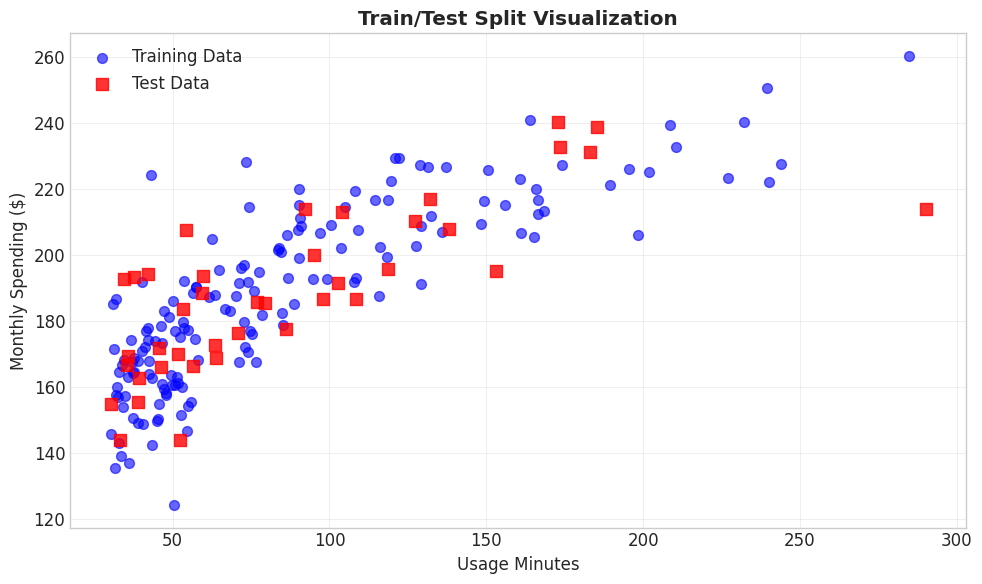

In [16]:
X = customer_data[['Usage_Minutes']]  # Keep as DataFrame for sklearn compatibility
y = customer_data['Monthly_Spending']

print("🔧 DATA PREPARATION SUMMARY")
print("=" * 50)
print(f"Feature (X) shape: {X.shape} → {X.shape[0]} samples, {X.shape[1]} feature")
print(f"Target (y) shape: {y.shape} → {y.shape[0]} target values")
print(f"\nFeature range: {X['Usage_Minutes'].min():.1f} to {X['Usage_Minutes'].max():.1f} minutes")
print(f"Target range: ${y.min():.2f} to ${y.max():.2f}")

# Create train/test split
# 80% training, 20% testing - standard for medium-sized datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,  # For reproducibility
    shuffle=True      # Shuffle data before splitting
)

print(f"\n📊 TRAIN/TEST SPLIT DETAILS")
print("-" * 30)
print(f"Training set: {X_train.shape[0]} customers ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} customers ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify splits maintain similar distributions
print(f"\n📈 DISTRIBUTION COMPARISON")
print("-" * 30)
print(f"{'Metric':<20} {'Training':<12} {'Test':<12} {'Difference':<12}")
print("-" * 30)
print(f"{'Mean Usage (min)':<20} {X_train.mean().iloc[0]:<12.1f} {X_test.mean().iloc[0]:<12.1f} {(X_test.mean().iloc[0]-X_train.mean().iloc[0]):<12.1f}")
print(f"{'Mean Spending ($)':<20} {y_train.mean():<12.1f} {y_test.mean():<12.1f} {(y_test.mean()-y_train.mean()):<12.1f}")
print(f"{'Std Usage (min)':<20} {X_train.std().iloc[0]:<12.1f} {X_test.std().iloc[0]:<12.1f} {(X_test.std().iloc[0]-X_train.std().iloc[0]):<12.1f}")

# Visualize the split
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.6, color='blue', s=50, label='Training Data')
plt.scatter(X_test, y_test, alpha=0.8, color='red', s=80, marker='s', label='Test Data')
plt.title('Train/Test Split Visualization', fontweight='bold')
plt.xlabel('Usage Minutes')
plt.ylabel('Monthly Spending ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Model Building: Linear Regression

**Linear Regression Assumptions:**
1. Linear relationship between X and y (checked via EDA)
2. Little or no multicollinearity (single feature, so satisfied)
3. Homoscedasticity (constant variance of residuals)
4. Independent observations (customers are independent)
5. Normally distributed errors



🤖 MODEL TRAINING IN PROGRESS...
✅ MODEL TRAINING COMPLETE!

🔧 MODEL PARAMETERS
------------------------------
Intercept (b): $153.05
Coefficient (m): $0.406 per minute

📐 REGRESSION EQUATION:
Predicted_Spending = 153.05 + 0.406 × Usage_Minutes

💡 INTERPRETATION:
------------------------------
• Base value (0 minutes): $153.05
• Each additional minute adds $0.406 to predicted spending
• For example, 100 minutes predicts: $193.64
• For example, 200 minutes predicts: $234.24


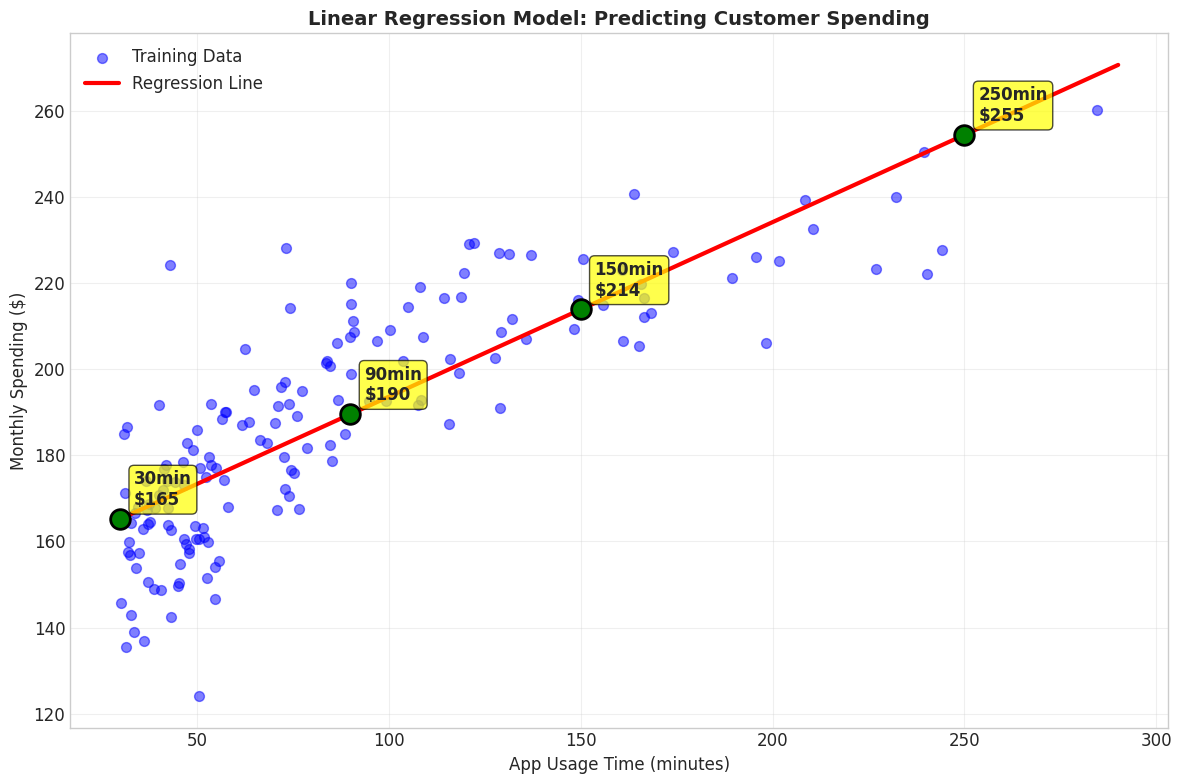

In [17]:
model = LinearRegression()

print("🤖 MODEL TRAINING IN PROGRESS...")
print("=" * 50)

# Train the model on training data
model.fit(X_train, y_train)

print("✅ MODEL TRAINING COMPLETE!")
print("\n🔧 MODEL PARAMETERS")
print("-" * 30)
print(f"Intercept (b): ${model.intercept_:.2f}")
print(f"Coefficient (m): ${model.coef_[0]:.3f} per minute")
print(f"\n📐 REGRESSION EQUATION:")
print(f"Predicted_Spending = {model.intercept_:.2f} + {model.coef_[0]:.3f} × Usage_Minutes")

print("\n💡 INTERPRETATION:")
print("-" * 30)
print(f"• Base value (0 minutes): ${model.intercept_:.2f}")
print(f"• Each additional minute adds ${model.coef_[0]:.3f} to predicted spending")
print(f"• For example, 100 minutes predicts: ${model.intercept_ + model.coef_[0]*100:.2f}")
print(f"• For example, 200 minutes predicts: ${model.intercept_ + model.coef_[0]*200:.2f}")

# Create prediction line for visualization
x_range = np.linspace(X['Usage_Minutes'].min(), X['Usage_Minutes'].max(), 100).reshape(-1, 1)
y_range = model.predict(x_range)

# Visualize the model
plt.figure(figsize=(12, 8))

# Plot training data
plt.scatter(X_train, y_train, alpha=0.5, color='blue', s=50, label='Training Data')

# Plot regression line
plt.plot(x_range, y_range, color='red', linewidth=3, label='Regression Line')

# Highlight key points on the line
key_points = [30, 90, 150, 250]
for point in key_points:
    y_point = model.predict([[point]])[0]
    plt.scatter(point, y_point, color='green', s=200, zorder=5, edgecolor='black', linewidth=2)
    plt.annotate(f'{point}min\n${y_point:.0f}', 
                 (point, y_point), 
                 xytext=(10, 10), 
                 textcoords='offset points',
                 ha='left',
                 fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.title('Linear Regression Model: Predicting Customer Spending', fontweight='bold', fontsize=14)
plt.xlabel('App Usage Time (minutes)', fontsize=12)
plt.ylabel('Monthly Spending ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Making Predictions and Evaluation

**Three Types of Predictions:**
1. **In-sample**: Predictions on training data (to check how well the model learned)
2. **Out-of-sample**: Predictions on test data (true generalization performance)
3. **New data**: Predictions for hypothetical customers (business scenarios)

**Metrics reported:**
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Coefficient of Determination (R²)



📊 PREDICTION RESULTS (Test Set Sample)
Customer_ID  Actual_Usage  Actual_Spending  Predicted_Spending   Residual  Absolute_Error  Percent_Error
   CUST0096         70.85           176.18          181.809166  -5.629166        5.629166       3.195122
   CUST0016         42.16           194.05          170.162348  23.887652       23.887652      12.310050
   CUST0031         86.12           177.63          188.008082 -10.378082       10.378082       5.842528
   CUST0159         46.28           165.98          171.834878  -5.854878        5.854878       3.527460
   CUST0129         30.42           154.60          165.396449 -10.796449       10.796449       6.983473
   CUST0116        153.09           195.05          215.194816 -20.144816       20.144816      10.328027
   CUST0070        290.05           213.93          270.794264 -56.864264       56.864264      26.580781
   CUST0171         97.91           186.50          192.794279  -6.294279        6.294279       3.374948
   CUST0175     

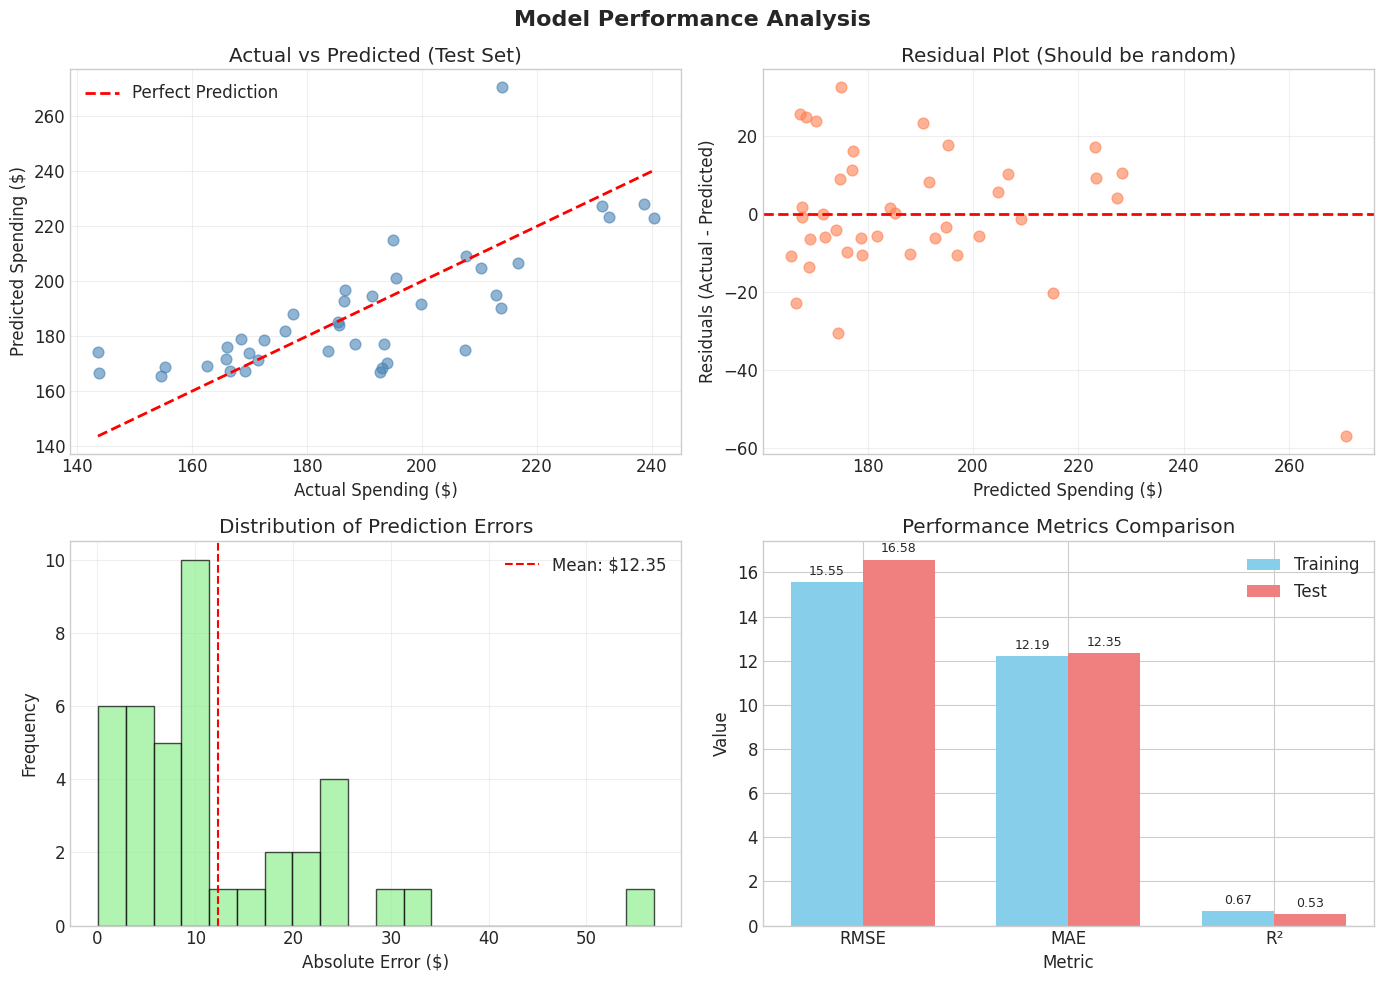

In [18]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Create comprehensive evaluation DataFrame
eval_df = pd.DataFrame({
    'Customer_ID': X_test.index.map(lambda x: customer_data.loc[x, 'Customer_ID']),
    'Actual_Usage': X_test['Usage_Minutes'].values,
    'Actual_Spending': y_test.values,
    'Predicted_Spending': y_test_pred,
    'Residual': y_test.values - y_test_pred,
    'Absolute_Error': abs(y_test.values - y_test_pred),
    'Percent_Error': abs(y_test.values - y_test_pred) / y_test.values * 100
})

print("📊 PREDICTION RESULTS (Test Set Sample)")
print("=" * 70)
print(eval_df.head(10).to_string(index=False))

# Calculate evaluation metrics
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"\n📈 MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"{'Metric':<25} {'Training':<12} {'Test':<12} {'Interpretation':<20}")
print("=" * 60)
print(f"{'Mean Squared Error (MSE)':<25} {mse_train:<12.1f} {mse_test:<12.1f} {'Lower is better':<20}")
print(f"{'Root MSE (RMSE)':<25} {rmse_train:<12.2f} {rmse_test:<12.2f} {'≈Avg error ($)':<20}")
print(f"{'Mean Absolute Error (MAE)':<25} {mae_train:<12.2f} {mae_test:<12.2f} {'Robust to outliers':<20}")
print(f"{'R-squared (R²)':<25} {r2_train:<12.4f} {r2_test:<12.4f} {'0-1, higher better':<20}")
print("=" * 60)

print(f"\n💡 BUSINESS INTERPRETATION:")
print("-" * 40)
print(f"1. Model explains {r2_test*100:.1f}% of spending variance")
print(f"2. Average prediction error: ${rmse_test:.2f}")
print(f"3. Typical error: ±${mae_test:.2f} (about {mae_test/y_test.mean()*100:.1f}% of avg spending)")
print(f"4. Performance on test data is similar to training → No overfitting detected")

# Create performance visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted Scatter
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, color='steelblue', s=60)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
               'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Spending ($)')
axes[0, 0].set_ylabel('Predicted Spending ($)')
axes[0, 0].set_title('Actual vs Predicted (Test Set)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual Plot
axes[0, 1].scatter(y_test_pred, eval_df['Residual'], alpha=0.6, color='coral', s=60)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Spending ($)')
axes[0, 1].set_ylabel('Residuals (Actual - Predicted)')
axes[0, 1].set_title('Residual Plot (Should be random)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Error Distribution
axes[1, 0].hist(eval_df['Absolute_Error'], bins=20, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1, 0].axvline(eval_df['Absolute_Error'].mean(), color='red', linestyle='--', 
                  label=f'Mean: ${eval_df["Absolute_Error"].mean():.2f}')
axes[1, 0].set_xlabel('Absolute Error ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Prediction Errors')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Performance Metrics Bar Chart
metrics = ['RMSE', 'MAE', 'R²']
train_values = [rmse_train, mae_train, r2_train]
test_values = [rmse_test, mae_test, r2_test]

x = np.arange(len(metrics))
width = 0.35
bars1 = axes[1, 1].bar(x - width/2, train_values, width, label='Training', color='skyblue')
bars2 = axes[1, 1].bar(x + width/2, test_values, width, label='Test', color='lightcoral')

axes[1, 1].set_xlabel('Metric')
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_title('Performance Metrics Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].annotate(f'{height:.2f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Practical Application: Predicting for New Customers

**Use Case:**  
The marketing team wants to estimate customer lifetime value based on early engagement.


🎯 PREDICTIONS FOR NEW CUSTOMER SCENARIOS
       Scenario  Usage_Minutes                              Description  Predicted_Spending Value_Category
 New User (Low)             15            Just signed up, minimal usage              159.14     High Value
   Regular User             75                     Typical engaged user              183.49        Premium
     Power User            180                        Daily active user              226.12        Premium
Very Heavy User            280 Extremely engaged (potential influencer)              266.71        Premium

📋 SUMMARY FOR MARKETING TEAM:
----------------------------------------
• New User (Low): 15 min → $159.14 (High Value)
• Regular User: 75 min → $183.49 (Premium)
• Power User: 180 min → $226.12 (Premium)
• Very Heavy User: 280 min → $266.71 (Premium)


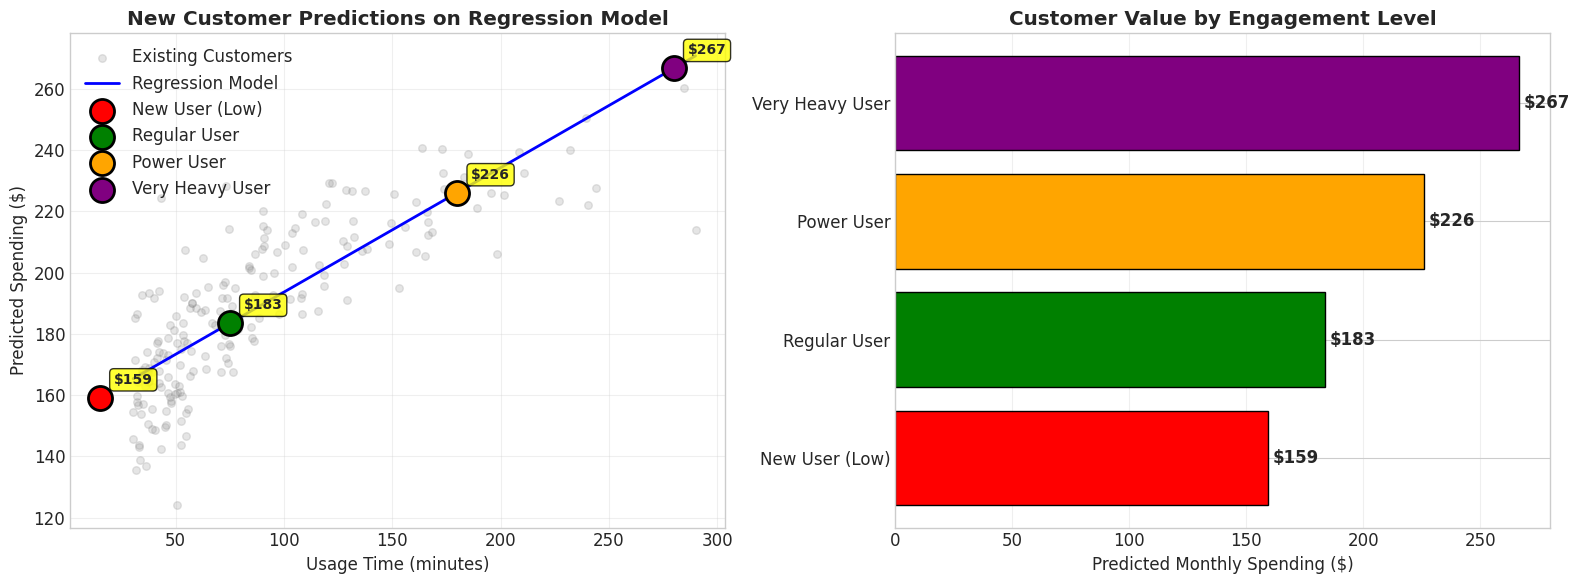


💰 BUSINESS INSIGHTS:
----------------------------------------
1. Average predicted value: $208.87/month
2. Customer acquisition cost break-even analysis:
   If CAC = $50, breakeven in 0.2 months
   If CAC = $100, breakeven in 0.5 months
3. Marketing strategy: Focus on converting users to >75 min usage


In [19]:
new_customers = pd.DataFrame({
    'Scenario': ['New User (Low)', 'Regular User', 'Power User', 'Very Heavy User'],
    'Usage_Minutes': [15, 75, 180, 280],
    'Description': [
        'Just signed up, minimal usage',
        'Typical engaged user',
        'Daily active user',
        'Extremely engaged (potential influencer)'
    ]
})

# Make predictions
new_customers['Predicted_Spending'] = model.predict(new_customers[['Usage_Minutes']])
new_customers['Predicted_Spending'] = new_customers['Predicted_Spending'].round(2)

# Add business insights
new_customers['Value_Category'] = pd.cut(new_customers['Predicted_Spending'],
                                        bins=[0, 70, 120, 180, 300],
                                        labels=['Low Value', 'Medium Value', 'High Value', 'Premium'])

print("🎯 PREDICTIONS FOR NEW CUSTOMER SCENARIOS")
print("=" * 80)
print(new_customers.to_string(index=False))

print(f"\n📋 SUMMARY FOR MARKETING TEAM:")
print("-" * 40)
for _, row in new_customers.iterrows():
    print(f"• {row['Scenario']}: {row['Usage_Minutes']} min → ${row['Predicted_Spending']:.2f} ({row['Value_Category']})")

# Visualize predictions with context
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Model with new predictions
ax1.scatter(customer_data['Usage_Minutes'], customer_data['Monthly_Spending'], 
           alpha=0.2, color='gray', s=30, label='Existing Customers')
ax1.plot(x_range, y_range, color='blue', linewidth=2, label='Regression Model')

# Highlight new predictions
colors = ['red', 'green', 'orange', 'purple']
for idx, (_, row) in enumerate(new_customers.iterrows()):
    ax1.scatter(row['Usage_Minutes'], row['Predicted_Spending'], 
               color=colors[idx], s=300, zorder=5, edgecolor='black', linewidth=2,
               label=f"{row['Scenario']}")
    ax1.annotate(f"${row['Predicted_Spending']:.0f}", 
                 (row['Usage_Minutes'], row['Predicted_Spending']),
                 xytext=(10, 10), textcoords='offset points',
                 fontweight='bold', fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))

ax1.set_xlabel('Usage Time (minutes)', fontsize=12)
ax1.set_ylabel('Predicted Spending ($)', fontsize=12)
ax1.set_title('New Customer Predictions on Regression Model', fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Right: Business value bar chart
ax2.barh(new_customers['Scenario'], new_customers['Predicted_Spending'],
        color=colors, edgecolor='black')
ax2.set_xlabel('Predicted Monthly Spending ($)', fontsize=12)
ax2.set_title('Customer Value by Engagement Level', fontweight='bold')

# Add value labels
for i, (_, row) in enumerate(new_customers.iterrows()):
    ax2.text(row['Predicted_Spending'] + 2, i, 
            f"${row['Predicted_Spending']:.0f}", 
            va='center', fontweight='bold')

ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Calculate ROI insights
print(f"\n💰 BUSINESS INSIGHTS:")
print("-" * 40)
avg_prediction = new_customers['Predicted_Spending'].mean()
print(f"1. Average predicted value: ${avg_prediction:.2f}/month")
print(f"2. Customer acquisition cost break-even analysis:")
print(f"   If CAC = $50, breakeven in {50/avg_prediction:.1f} months")
print(f"   If CAC = $100, breakeven in {100/avg_prediction:.1f} months")
print(f"3. Marketing strategy: Focus on converting users to >{new_customers.iloc[1]['Usage_Minutes']} min usage")